In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/BanglaCharacterDataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Train/201/bcc000060.bmp  
  inflating: Dataset/Train/201/bcc000061.bmp  
  inflating: Dataset/Train/201/bcc000062.bmp  
  inflating: Dataset/Train/201/bcc000063.bmp  
  inflating: Dataset/Train/201/bcc000064.bmp  
  inflating: Dataset/Train/201/bcc000065.bmp  
  inflating: Dataset/Train/201/bcc000066.bmp  
  inflating: Dataset/Train/201/bcc000067.bmp  
  inflating: Dataset/Train/201/bcc000068.bmp  
  inflating: Dataset/Train/201/bcc000069.bmp  
  inflating: Dataset/Train/201/bcc000070.bmp  
  inflating: Dataset/Train/201/bcc000071.bmp  
  inflating: Dataset/Train/201/bcc000072.bmp  
  inflating: Dataset/Train/201/bcc000073.bmp  
  inflating: Dataset/Train/201/bcc000074.bmp  
  inflating: Dataset/Train/201/bcc000075.bmp  
  inflating: Dataset/Train/201/bcc000076.bmp  
  inflating: Dataset/Train/201/bcc000077.bmp  
  inflating: Dataset/Train/201/bcc000078.bmp  
  inflating: Dataset/Train/201/bcc000079.bmp  
  inflati

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import functional as Flatten
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchsummary import summary

import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import random

import warnings as wrn
wrn.filterwarnings('ignore')

In [ ]:
ROOT_DIR = '/content/Dataset'
TRAIN_ROOT = os.path.join(ROOT_DIR, 'Train')
TEST_ROOT = os.path.join(ROOT_DIR, 'Test')
CHECKPOINT = ''

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

IMG_SIZE = (32, 32)
BATCH_SIZE = 32

N_CLASSES = len(os.listdir(TRAIN_ROOT))

In [ ]:
paths = glob.glob('/content/Dataset/*/*/*.bmp')

df = pd.DataFrame({'Path': paths})

def extract_label(path):
    return path.split('/')[-2]

def extract_set(path):
    return path.split('/')[-3]

df['Label'] = df['Path'].apply(extract_label)
df = pd.concat([df, pd.get_dummies(df['Label'])], axis = 1)

df['Set'] = df['Path'].apply(extract_set)

train_df = df.loc[df['Set'] == 'Train'].iloc[:, :-1]
test_df = df.loc[df['Set'] == 'Test'].iloc[:, :-1]

In [ ]:
df

,Path,Label,172,173,174,175,176,177,178,179,...,213,214,215,216,217,218,219,220,221,Set
0,/content/Dataset/Train/200/bcc000183.bmp,200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Train
1,/content/Dataset/Train/200/bcc000108.bmp,200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Train
2,/content/Dataset/Train/200/bcc000145.bmp,200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Train
3,/content/Dataset/Train/200/bcc000171.bmp,200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Train
4,/content/Dataset/Train/200/bcc000082.bmp,200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,/content/Dataset/Test/181/bcc000020.bmp,181,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Test
14996,/content/Dataset/Test/181/bcc000015.bmp,181,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Test
14997,/content/Dataset/Test/181/bcc000055.bmp,181,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Test
14998,/content/Dataset/Test/181/bcc000016.bmp,181,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Test


In [ ]:
train_df

,Path,Label,172,173,174,175,176,177,178,179,...,212,213,214,215,216,217,218,219,220,221
0,/content/Dataset/Train/200/bcc000183.bmp,200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,/content/Dataset/Train/200/bcc000108.bmp,200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,/content/Dataset/Train/200/bcc000145.bmp,200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,/content/Dataset/Train/200/bcc000171.bmp,200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,/content/Dataset/Train/200/bcc000082.bmp,200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,/content/Dataset/Train/181/bcc000181.bmp,181,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11996,/content/Dataset/Train/181/bcc000086.bmp,181,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11997,/content/Dataset/Train/181/bcc000067.bmp,181,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11998,/content/Dataset/Train/181/bcc000066.bmp,181,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_df

,Path,Label,172,173,174,175,176,177,178,179,...,212,213,214,215,216,217,218,219,220,221
12000,/content/Dataset/Test/200/bcc000034.bmp,200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12001,/content/Dataset/Test/200/bcc000057.bmp,200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12002,/content/Dataset/Test/200/bcc000000.bmp,200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12003,/content/Dataset/Test/200/bcc000006.bmp,200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12004,/content/Dataset/Test/200/bcc000044.bmp,200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,/content/Dataset/Test/181/bcc000020.bmp,181,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14996,/content/Dataset/Test/181/bcc000015.bmp,181,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14997,/content/Dataset/Test/181/bcc000055.bmp,181,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14998,/content/Dataset/Test/181/bcc000016.bmp,181,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(75, 80, 3)


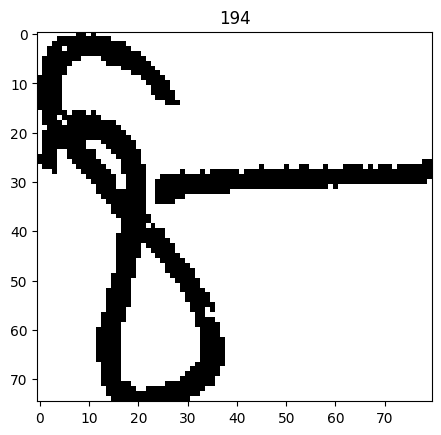

In [ ]:
import matplotlib.pyplot as plt
import random

def imshow():
    idx = random.randint(0, len(train_df))
    img = plt.imread(train_df['Path'][idx])
    label = train_df['Label'][idx]
    print(img.shape)
    plt.imshow(img)
    plt.title(label)
    plt.show()

imshow()

In [ ]:
class CustomDatasetLoader(torch.utils.data.Dataset):

    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx, 0]
        img = cv2.imread(path)

        if self.transform:
            img = self.transform(img)

        label = torch.from_numpy(self.df.iloc[idx, 2:].values.astype(float))

        return (img, label)

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(IMG_SIZE),
    # torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.ToTensor(),
])

train_data = CustomDatasetLoader(df = train_df, transform = transform)
test_data = CustomDatasetLoader(df = test_df, transform = transform)
all_data = CustomDatasetLoader(df = df.iloc[:, :-1], transform = transform)

train_loader = torch.utils.data.DataLoader(
    dataset = train_data, batch_size = 32, shuffle = True, num_workers = 1, drop_last = True
)
test_loader = torch.utils.data.DataLoader(
    dataset = test_data, batch_size = 64, shuffle = True, num_workers = 1, drop_last = False
)
all_data_loader = torch.utils.data.DataLoader(
    dataset = all_data, batch_size = 64, shuffle = True, num_workers = 1, drop_last = False
)

In [ ]:
for (images, labels) in all_data_loader:
    print(images.shape)
    print(labels.shape)
    break

all_data.__len__()

torch.Size([64, 3, 32, 32])
torch.Size([64, 50])


15000

In [ ]:
# conv out = ((i+2p-k)/s)+1
# convtrans out = (i-1)*s+k-2p

In [ ]:
class VanillaVAE(nn.Module):
    def __init__(self, z_embedding_dim = 32):
        super(VanillaVAE, self).__init__()
        self.z_embedding_dim = z_embedding_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=2, stride=2, padding=0),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=2, stride=1, padding=0),
            nn.LeakyReLU(),
        )

        self.fc_mu = nn.Linear(in_features=1*1*256, out_features=z_embedding_dim)
        self.fc_var = nn.Linear(in_features=1*1*256, out_features=z_embedding_dim)

        self.decoder_input = nn.Linear(in_features=z_embedding_dim, out_features=1*1*256)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1*1*256, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=2, stride=2, padding=2),
            nn.Sigmoid(),
        )


    ###############
    def encode(self, input):
        result = self.encoder(input) # BSx1x1x256
        result = result.view(result.size(0), -1) # BSx(1*1*256)
        mu = self.fc_mu(result) # BSx128
        log_var = self.fc_var(result) # BSx128
        return (mu, log_var)

    ###############
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        esp = torch.randn_like(std)
        z = mu + std * esp
        return z.to(DEVICE)

    ###############
    def decode(self, z):
        dec_inp = self.decoder_input(z) #BSx(1*1*256)
        dec_inp = dec_inp.view(dec_inp.size(0), 1*1*256, 1, 1) # BSx1x1x256
        recon_img = self.decoder(dec_inp)
        return recon_img

    ###############
    def forward(self, img):
        mu, logvar = self.encode(img)
        z = self.reparameterize(mu, logvar)
        recon_img = self.decode(z)
        return (z, mu, logvar, recon_img)


In [ ]:
model = VanillaVAE(z_embedding_dim = 64).to(DEVICE)

In [ ]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
         LeakyReLU-2           [-1, 32, 30, 30]               0
            Conv2d-3           [-1, 32, 15, 15]           4,128
         LeakyReLU-4           [-1, 32, 15, 15]               0
            Conv2d-5           [-1, 64, 13, 13]          18,496
         LeakyReLU-6           [-1, 64, 13, 13]               0
            Conv2d-7             [-1, 64, 6, 6]          16,448
         LeakyReLU-8             [-1, 64, 6, 6]               0
            Conv2d-9            [-1, 128, 4, 4]          73,856
        LeakyReLU-10            [-1, 128, 4, 4]               0
           Conv2d-11            [-1, 128, 2, 2]          65,664
        LeakyReLU-12            [-1, 128, 2, 2]               0
           Conv2d-13            [-1, 256, 1, 1]         131,328
        LeakyReLU-14            [-1, 25

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def criterion(recon_img, img, mu, logvar):
    # recon_loss = F.mse_loss(recon_img, img)
    recon_loss = F.binary_cross_entropy(recon_img, img, size_average=False)
    KLD = torch.mean(-0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp(), dim=1), dim=0)
    return recon_loss+KLD, recon_loss, KLD

In [ ]:
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for idx, batch in enumerate(tqdm(iterator)):
        images, _ = batch
        images = images.to(DEVICE)
        optimizer.zero_grad()
        z, mu, logvar, recon_imgs = model(images)
        loss, recon_loss, kld_loss = criterion(recon_imgs, images, mu, logvar)
        loss.backward()
        optimizer.step()
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=1)
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [ ]:
best_loss = 1e10
for epoch in range(201):
    if os.path.exists('model.pth'):
        model.load_state_dict(torch.load('model.pth'))
    print(f"Epoch - {epoch}")
    loss = train(model, train_loader, optimizer, criterion)
    print(f"Loss - {loss:.2f}\n")

    if epoch % 10 == 0 and loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), "model.pth")
        print(f"{'-'*20}\nModel Saved\n{'-'*20}")

Epoch - 0


100%|██████████| 375/375 [00:12<00:00, 30.98it/s]


Loss - 64247.56

--------------------
Model Saved
--------------------
Epoch - 1


100%|██████████| 375/375 [00:09<00:00, 39.56it/s]


Loss - 62226.91

Epoch - 2


100%|██████████| 375/375 [00:10<00:00, 35.70it/s]


Loss - 62367.65

Epoch - 3


100%|██████████| 375/375 [00:10<00:00, 35.38it/s]


Loss - 62362.18

Epoch - 4


100%|██████████| 375/375 [00:10<00:00, 35.30it/s]


Loss - 62335.63

Epoch - 5


100%|██████████| 375/375 [00:09<00:00, 40.21it/s]


Loss - 62329.49

Epoch - 6


100%|██████████| 375/375 [00:10<00:00, 36.04it/s]


Loss - 62358.56

Epoch - 7


100%|██████████| 375/375 [00:10<00:00, 35.22it/s]


Loss - 62371.63

Epoch - 8


100%|██████████| 375/375 [00:10<00:00, 35.01it/s]


Loss - 62329.58

Epoch - 9


100%|██████████| 375/375 [00:09<00:00, 40.58it/s]


Loss - 62344.01

Epoch - 10


100%|██████████| 375/375 [00:10<00:00, 35.19it/s]


Loss - 62349.66

--------------------
Model Saved
--------------------
Epoch - 11


100%|██████████| 375/375 [00:10<00:00, 35.45it/s]


Loss - 61397.98

Epoch - 12


100%|██████████| 375/375 [00:10<00:00, 35.06it/s]


Loss - 61351.80

Epoch - 13


100%|██████████| 375/375 [00:09<00:00, 40.31it/s]


Loss - 61369.05

Epoch - 14


100%|██████████| 375/375 [00:10<00:00, 35.07it/s]


Loss - 61368.01

Epoch - 15


100%|██████████| 375/375 [00:10<00:00, 34.72it/s]


Loss - 61350.36

Epoch - 16


100%|██████████| 375/375 [00:12<00:00, 31.01it/s]


Loss - 61314.45

Epoch - 17


100%|██████████| 375/375 [00:10<00:00, 37.34it/s]


Loss - 61382.50

Epoch - 18


100%|██████████| 375/375 [00:09<00:00, 38.05it/s]


Loss - 61325.28

Epoch - 19


100%|██████████| 375/375 [00:10<00:00, 35.15it/s]


Loss - 61440.71

Epoch - 20


100%|██████████| 375/375 [00:10<00:00, 34.74it/s]


Loss - 61330.60

--------------------
Model Saved
--------------------
Epoch - 21


100%|██████████| 375/375 [00:10<00:00, 37.29it/s]


Loss - 60396.41

Epoch - 22


100%|██████████| 375/375 [00:09<00:00, 38.23it/s]


Loss - 60377.76

Epoch - 23


100%|██████████| 375/375 [00:10<00:00, 35.20it/s]


Loss - 60416.06

Epoch - 24


100%|██████████| 375/375 [00:10<00:00, 35.15it/s]


Loss - 60414.53

Epoch - 25


100%|██████████| 375/375 [00:09<00:00, 37.69it/s]


Loss - 60389.88

Epoch - 26


100%|██████████| 375/375 [00:09<00:00, 37.76it/s]


Loss - 60372.49

Epoch - 27


100%|██████████| 375/375 [00:10<00:00, 34.95it/s]


Loss - 60370.91

Epoch - 28


100%|██████████| 375/375 [00:10<00:00, 35.75it/s]


Loss - 60380.85

Epoch - 29


100%|██████████| 375/375 [00:10<00:00, 37.28it/s]


Loss - 60360.38

Epoch - 30


100%|██████████| 375/375 [00:09<00:00, 38.60it/s]


Loss - 60391.80

--------------------
Model Saved
--------------------
Epoch - 31


100%|██████████| 375/375 [00:10<00:00, 34.89it/s]


Loss - 59677.42

Epoch - 32


100%|██████████| 375/375 [00:10<00:00, 35.43it/s]


Loss - 59678.80

Epoch - 33


100%|██████████| 375/375 [00:09<00:00, 38.19it/s]


Loss - 59654.64

Epoch - 34


100%|██████████| 375/375 [00:10<00:00, 37.35it/s]


Loss - 59648.46

Epoch - 35


100%|██████████| 375/375 [00:10<00:00, 35.27it/s]


Loss - 59668.07

Epoch - 36


100%|██████████| 375/375 [00:10<00:00, 35.30it/s]


Loss - 59691.96

Epoch - 37


100%|██████████| 375/375 [00:09<00:00, 37.69it/s]


Loss - 59647.74

Epoch - 38


100%|██████████| 375/375 [00:09<00:00, 37.78it/s]


Loss - 59632.30

Epoch - 39


100%|██████████| 375/375 [00:10<00:00, 34.91it/s]


Loss - 59653.32

Epoch - 40


100%|██████████| 375/375 [00:12<00:00, 31.17it/s]


Loss - 59660.42

--------------------
Model Saved
--------------------
Epoch - 41


100%|██████████| 375/375 [00:10<00:00, 36.72it/s]


Loss - 59186.31

Epoch - 42


100%|██████████| 375/375 [00:09<00:00, 38.47it/s]


Loss - 59252.06

Epoch - 43


100%|██████████| 375/375 [00:10<00:00, 35.33it/s]


Loss - 59207.83

Epoch - 44


100%|██████████| 375/375 [00:10<00:00, 34.99it/s]


Loss - 59164.43

Epoch - 45


100%|██████████| 375/375 [00:10<00:00, 36.98it/s]


Loss - 59141.09

Epoch - 46


100%|██████████| 375/375 [00:09<00:00, 38.05it/s]


Loss - 59156.30

Epoch - 47


100%|██████████| 375/375 [00:10<00:00, 34.96it/s]


Loss - 59157.97

Epoch - 48


100%|██████████| 375/375 [00:10<00:00, 35.12it/s]


Loss - 59173.13

Epoch - 49


100%|██████████| 375/375 [00:10<00:00, 36.67it/s]


Loss - 59169.13

Epoch - 50


100%|██████████| 375/375 [00:09<00:00, 38.48it/s]


Loss - 59138.66

--------------------
Model Saved
--------------------
Epoch - 51


100%|██████████| 375/375 [00:10<00:00, 35.20it/s]


Loss - 58813.80

Epoch - 52


100%|██████████| 375/375 [00:10<00:00, 34.68it/s]


Loss - 58870.74

Epoch - 53


100%|██████████| 375/375 [00:10<00:00, 34.82it/s]


Loss - 58776.11

Epoch - 54


100%|██████████| 375/375 [00:09<00:00, 40.16it/s]


Loss - 58789.75

Epoch - 55


100%|██████████| 375/375 [00:10<00:00, 34.99it/s]


Loss - 58744.56

Epoch - 56


100%|██████████| 375/375 [00:10<00:00, 35.28it/s]


Loss - 58755.81

Epoch - 57


100%|██████████| 375/375 [00:10<00:00, 36.33it/s]


Loss - 58790.63

Epoch - 58


100%|██████████| 375/375 [00:09<00:00, 39.53it/s]


Loss - 58747.56

Epoch - 59


100%|██████████| 375/375 [00:10<00:00, 35.51it/s]


Loss - 58793.82

Epoch - 60


100%|██████████| 375/375 [00:10<00:00, 35.40it/s]


Loss - 58742.38

--------------------
Model Saved
--------------------
Epoch - 61


100%|██████████| 375/375 [00:10<00:00, 36.38it/s]


Loss - 58414.40

Epoch - 62


100%|██████████| 375/375 [00:09<00:00, 39.24it/s]


Loss - 58413.98

Epoch - 63


100%|██████████| 375/375 [00:10<00:00, 35.51it/s]


Loss - 58432.81

Epoch - 64


100%|██████████| 375/375 [00:10<00:00, 34.71it/s]


Loss - 58381.45

Epoch - 65


100%|██████████| 375/375 [00:11<00:00, 32.56it/s]


Loss - 58377.19

Epoch - 66


100%|██████████| 375/375 [00:09<00:00, 41.01it/s]


Loss - 58365.82

Epoch - 67


100%|██████████| 375/375 [00:10<00:00, 35.57it/s]


Loss - 58353.88

Epoch - 68


100%|██████████| 375/375 [00:10<00:00, 35.32it/s]


Loss - 58448.38

Epoch - 69


100%|██████████| 375/375 [00:10<00:00, 35.63it/s]


Loss - 58390.42

Epoch - 70


100%|██████████| 375/375 [00:09<00:00, 40.40it/s]


Loss - 58387.51

--------------------
Model Saved
--------------------
Epoch - 71


100%|██████████| 375/375 [00:10<00:00, 35.58it/s]


Loss - 58097.20

Epoch - 72


100%|██████████| 375/375 [00:10<00:00, 35.49it/s]


Loss - 58046.63

Epoch - 73


100%|██████████| 375/375 [00:10<00:00, 35.44it/s]


Loss - 58103.56

Epoch - 74


100%|██████████| 375/375 [00:09<00:00, 40.77it/s]


Loss - 58049.16

Epoch - 75


100%|██████████| 375/375 [00:10<00:00, 35.39it/s]


Loss - 58093.16

Epoch - 76


100%|██████████| 375/375 [00:10<00:00, 35.49it/s]


Loss - 58102.08

Epoch - 77


100%|██████████| 375/375 [00:10<00:00, 36.24it/s]


Loss - 58064.32

Epoch - 78


100%|██████████| 375/375 [00:09<00:00, 39.59it/s]


Loss - 58080.76

Epoch - 79


100%|██████████| 375/375 [00:10<00:00, 35.31it/s]


Loss - 58092.47

Epoch - 80


100%|██████████| 375/375 [00:10<00:00, 35.76it/s]


Loss - 58168.57

--------------------
Model Saved
--------------------
Epoch - 81


100%|██████████| 375/375 [00:10<00:00, 35.86it/s]


Loss - 57817.96

Epoch - 82


100%|██████████| 375/375 [00:09<00:00, 40.58it/s]


Loss - 57771.36

Epoch - 83


100%|██████████| 375/375 [00:10<00:00, 35.23it/s]


Loss - 57784.45

Epoch - 84


100%|██████████| 375/375 [00:10<00:00, 35.17it/s]


Loss - 57790.67

Epoch - 85


100%|██████████| 375/375 [00:10<00:00, 35.18it/s]


Loss - 57830.08

Epoch - 86


100%|██████████| 375/375 [00:09<00:00, 40.34it/s]


Loss - 57768.57

Epoch - 87


100%|██████████| 375/375 [00:10<00:00, 35.78it/s]


Loss - 57833.41

Epoch - 88


100%|██████████| 375/375 [00:10<00:00, 35.34it/s]


Loss - 57825.00

Epoch - 89


100%|██████████| 375/375 [00:10<00:00, 35.79it/s]


Loss - 57838.87

Epoch - 90


100%|██████████| 375/375 [00:10<00:00, 35.33it/s]


Loss - 57796.77

--------------------
Model Saved
--------------------
Epoch - 91


100%|██████████| 375/375 [00:10<00:00, 35.15it/s]


Loss - 57594.46

Epoch - 92


100%|██████████| 375/375 [00:10<00:00, 35.62it/s]


Loss - 57570.59

Epoch - 93


100%|██████████| 375/375 [00:10<00:00, 36.58it/s]


Loss - 57610.05

Epoch - 94


100%|██████████| 375/375 [00:09<00:00, 38.18it/s]


Loss - 57579.03

Epoch - 95


100%|██████████| 375/375 [00:10<00:00, 35.52it/s]


Loss - 57529.23

Epoch - 96


100%|██████████| 375/375 [00:10<00:00, 35.43it/s]


Loss - 57576.51

Epoch - 97


100%|██████████| 375/375 [00:10<00:00, 36.01it/s]


Loss - 57621.70

Epoch - 98


100%|██████████| 375/375 [00:09<00:00, 39.95it/s]


Loss - 57573.50

Epoch - 99


100%|██████████| 375/375 [00:10<00:00, 35.44it/s]


Loss - 57628.39

Epoch - 100


100%|██████████| 375/375 [00:10<00:00, 35.00it/s]


Loss - 57557.55

--------------------
Model Saved
--------------------
Epoch - 101


100%|██████████| 375/375 [00:10<00:00, 36.33it/s]


Loss - 57375.16

Epoch - 102


100%|██████████| 375/375 [00:09<00:00, 38.87it/s]


Loss - 57380.93

Epoch - 103


100%|██████████| 375/375 [00:10<00:00, 35.39it/s]


Loss - 57382.89

Epoch - 104


100%|██████████| 375/375 [00:10<00:00, 35.35it/s]


Loss - 57513.49

Epoch - 105


100%|██████████| 375/375 [00:10<00:00, 36.22it/s]


Loss - 57373.09

Epoch - 106


100%|██████████| 375/375 [00:09<00:00, 39.41it/s]


Loss - 57428.64

Epoch - 107


100%|██████████| 375/375 [00:10<00:00, 35.15it/s]


Loss - 57347.41

Epoch - 108


100%|██████████| 375/375 [00:10<00:00, 35.38it/s]


Loss - 57376.51

Epoch - 109


100%|██████████| 375/375 [00:10<00:00, 36.46it/s]


Loss - 57390.46

Epoch - 110


100%|██████████| 375/375 [00:09<00:00, 39.64it/s]


Loss - 57350.78

--------------------
Model Saved
--------------------
Epoch - 111


100%|██████████| 375/375 [00:10<00:00, 35.50it/s]


Loss - 57188.12

Epoch - 112


100%|██████████| 375/375 [00:10<00:00, 35.46it/s]


Loss - 57203.94

Epoch - 113


100%|██████████| 375/375 [00:10<00:00, 37.12it/s]


Loss - 57232.47

Epoch - 114


100%|██████████| 375/375 [00:11<00:00, 33.99it/s]


Loss - 57215.16

Epoch - 115


100%|██████████| 375/375 [00:10<00:00, 35.26it/s]


Loss - 57346.37

Epoch - 116


100%|██████████| 375/375 [00:10<00:00, 35.42it/s]


Loss - 57188.16

Epoch - 117


100%|██████████| 375/375 [00:10<00:00, 35.23it/s]


Loss - 57331.08

Epoch - 118


100%|██████████| 375/375 [00:09<00:00, 40.21it/s]


Loss - 57224.56

Epoch - 119


100%|██████████| 375/375 [00:10<00:00, 34.98it/s]


Loss - 57196.25

Epoch - 120


100%|██████████| 375/375 [00:10<00:00, 35.02it/s]


Loss - 57221.61

--------------------
Model Saved
--------------------
Epoch - 121


100%|██████████| 375/375 [00:10<00:00, 35.16it/s]


Loss - 57076.68

Epoch - 122


100%|██████████| 375/375 [00:09<00:00, 40.35it/s]


Loss - 57127.56

Epoch - 123


100%|██████████| 375/375 [00:10<00:00, 35.16it/s]


Loss - 57105.75

Epoch - 124


100%|██████████| 375/375 [00:10<00:00, 35.12it/s]


Loss - 57072.59

Epoch - 125


100%|██████████| 375/375 [00:10<00:00, 34.90it/s]


Loss - 57107.08

Epoch - 126


100%|██████████| 375/375 [00:09<00:00, 39.48it/s]


Loss - 57105.73

Epoch - 127


100%|██████████| 375/375 [00:10<00:00, 35.97it/s]


Loss - 57054.65

Epoch - 128


100%|██████████| 375/375 [00:10<00:00, 35.45it/s]


Loss - 57107.91

Epoch - 129


100%|██████████| 375/375 [00:10<00:00, 35.56it/s]


Loss - 57113.66

Epoch - 130


100%|██████████| 375/375 [00:09<00:00, 40.69it/s]


Loss - 57074.39

--------------------
Model Saved
--------------------
Epoch - 131


100%|██████████| 375/375 [00:10<00:00, 35.44it/s]


Loss - 56907.88

Epoch - 132


100%|██████████| 375/375 [00:10<00:00, 35.32it/s]


Loss - 56946.23

Epoch - 133


100%|██████████| 375/375 [00:10<00:00, 34.81it/s]


Loss - 56984.11

Epoch - 134


100%|██████████| 375/375 [00:09<00:00, 39.87it/s]


Loss - 56914.42

Epoch - 135


100%|██████████| 375/375 [00:10<00:00, 35.57it/s]


Loss - 56965.52

Epoch - 136


100%|██████████| 375/375 [00:10<00:00, 35.64it/s]


Loss - 56933.74

Epoch - 137


100%|██████████| 375/375 [00:10<00:00, 35.28it/s]


Loss - 56932.02

Epoch - 138


100%|██████████| 375/375 [00:09<00:00, 40.56it/s]


Loss - 56933.95

Epoch - 139


100%|██████████| 375/375 [00:12<00:00, 31.24it/s]


Loss - 56958.53

Epoch - 140


100%|██████████| 375/375 [00:10<00:00, 35.05it/s]


Loss - 56949.84

--------------------
Model Saved
--------------------
Epoch - 141


100%|██████████| 375/375 [00:10<00:00, 35.21it/s]


Loss - 56839.98

Epoch - 142


100%|██████████| 375/375 [00:09<00:00, 38.15it/s]


Loss - 56990.88

Epoch - 143


100%|██████████| 375/375 [00:09<00:00, 37.92it/s]


Loss - 56789.78

Epoch - 144


100%|██████████| 375/375 [00:10<00:00, 35.43it/s]


Loss - 56757.45

Epoch - 145


100%|██████████| 375/375 [00:10<00:00, 35.35it/s]


Loss - 56799.81

Epoch - 146


100%|██████████| 375/375 [00:09<00:00, 38.10it/s]


Loss - 56880.40

Epoch - 147


100%|██████████| 375/375 [00:10<00:00, 37.41it/s]


Loss - 56845.87

Epoch - 148


100%|██████████| 375/375 [00:10<00:00, 35.20it/s]


Loss - 56804.48

Epoch - 149


100%|██████████| 375/375 [00:10<00:00, 35.25it/s]


Loss - 56779.59

Epoch - 150


100%|██████████| 375/375 [00:10<00:00, 37.17it/s]


Loss - 56774.93

--------------------
Model Saved
--------------------
Epoch - 151


100%|██████████| 375/375 [00:09<00:00, 38.15it/s]


Loss - 56682.65

Epoch - 152


100%|██████████| 375/375 [00:10<00:00, 35.37it/s]


Loss - 57891.92

Epoch - 153


100%|██████████| 375/375 [00:10<00:00, 35.16it/s]


Loss - 56566.24

Epoch - 154


100%|██████████| 375/375 [00:10<00:00, 36.63it/s]


Loss - 56618.28

Epoch - 155


100%|██████████| 375/375 [00:09<00:00, 38.27it/s]


Loss - 56623.65

Epoch - 156


100%|██████████| 375/375 [00:10<00:00, 34.57it/s]


Loss - 56760.96

Epoch - 157


100%|██████████| 375/375 [00:10<00:00, 35.01it/s]


Loss - 56690.68

Epoch - 158


100%|██████████| 375/375 [00:10<00:00, 35.84it/s]


Loss - 56657.28

Epoch - 159


100%|██████████| 375/375 [00:09<00:00, 39.28it/s]


Loss - 56669.88

Epoch - 160


100%|██████████| 375/375 [00:10<00:00, 35.22it/s]


Loss - 56685.01

--------------------
Model Saved
--------------------
Epoch - 161


100%|██████████| 375/375 [00:10<00:00, 34.59it/s]


Loss - 56620.14

Epoch - 162


100%|██████████| 375/375 [00:10<00:00, 34.64it/s]


Loss - 56559.26

Epoch - 163


100%|██████████| 375/375 [00:09<00:00, 40.01it/s]


Loss - 56577.17

Epoch - 164


100%|██████████| 375/375 [00:12<00:00, 30.49it/s]


Loss - 56607.93

Epoch - 165


100%|██████████| 375/375 [00:10<00:00, 34.82it/s]


Loss - 59083.87

Epoch - 166


100%|██████████| 375/375 [00:10<00:00, 34.82it/s]


Loss - 56461.70

Epoch - 167


100%|██████████| 375/375 [00:10<00:00, 37.34it/s]


Loss - 56479.08

Epoch - 168


100%|██████████| 375/375 [00:09<00:00, 37.77it/s]


Loss - 56506.63

Epoch - 169


100%|██████████| 375/375 [00:10<00:00, 35.07it/s]


Loss - 56535.75

Epoch - 170


100%|██████████| 375/375 [00:10<00:00, 35.28it/s]


Loss - 56564.71

--------------------
Model Saved
--------------------
Epoch - 171


100%|██████████| 375/375 [00:10<00:00, 34.69it/s]


Loss - 56441.38

Epoch - 172


100%|██████████| 375/375 [00:09<00:00, 38.69it/s]


Loss - 56449.33

Epoch - 173


100%|██████████| 375/375 [00:10<00:00, 35.43it/s]


Loss - 56489.85

Epoch - 174


100%|██████████| 375/375 [00:11<00:00, 33.87it/s]


Loss - 56430.94

Epoch - 175


100%|██████████| 375/375 [00:10<00:00, 34.83it/s]


Loss - 56469.66

Epoch - 176


100%|██████████| 375/375 [00:09<00:00, 40.39it/s]


Loss - 56582.52

Epoch - 177


100%|██████████| 375/375 [00:10<00:00, 34.72it/s]


Loss - 56500.98

Epoch - 178


100%|██████████| 375/375 [00:10<00:00, 35.16it/s]


Loss - 56441.41

Epoch - 179


100%|██████████| 375/375 [00:10<00:00, 34.90it/s]


Loss - 56481.17

Epoch - 180


100%|██████████| 375/375 [00:09<00:00, 39.88it/s]


Loss - 56550.14

--------------------
Model Saved
--------------------
Epoch - 181


100%|██████████| 375/375 [00:10<00:00, 35.14it/s]


Loss - 56377.54

Epoch - 182


100%|██████████| 375/375 [00:10<00:00, 34.99it/s]


Loss - 56409.39

Epoch - 183


100%|██████████| 375/375 [00:10<00:00, 34.83it/s]


Loss - 56444.59

Epoch - 184


100%|██████████| 375/375 [00:09<00:00, 39.60it/s]


Loss - 56402.57

Epoch - 185


100%|██████████| 375/375 [00:10<00:00, 35.54it/s]


Loss - 56484.99

Epoch - 186


100%|██████████| 375/375 [00:10<00:00, 34.71it/s]


Loss - 56429.78

Epoch - 187


100%|██████████| 375/375 [00:10<00:00, 34.47it/s]


Loss - 56378.92

Epoch - 188


100%|██████████| 375/375 [00:09<00:00, 38.30it/s]


Loss - 56562.94

Epoch - 189


100%|██████████| 375/375 [00:11<00:00, 32.23it/s]


Loss - 56402.08

Epoch - 190


100%|██████████| 375/375 [00:10<00:00, 35.00it/s]


Loss - 56363.55

--------------------
Model Saved
--------------------
Epoch - 191


100%|██████████| 375/375 [00:10<00:00, 34.78it/s]


Loss - 56272.31

Epoch - 192


100%|██████████| 375/375 [00:10<00:00, 34.83it/s]


Loss - 56310.55

Epoch - 193


100%|██████████| 375/375 [00:09<00:00, 39.64it/s]


Loss - 56277.94

Epoch - 194


100%|██████████| 375/375 [00:10<00:00, 35.14it/s]


Loss - 56368.01

Epoch - 195


100%|██████████| 375/375 [00:10<00:00, 34.95it/s]


Loss - 56324.30

Epoch - 196


100%|██████████| 375/375 [00:10<00:00, 34.94it/s]


Loss - 56293.18

Epoch - 197


100%|██████████| 375/375 [00:09<00:00, 39.45it/s]


Loss - 56299.63

Epoch - 198


100%|██████████| 375/375 [00:10<00:00, 35.00it/s]


Loss - 56324.05

Epoch - 199


100%|██████████| 375/375 [00:10<00:00, 34.45it/s]


Loss - 56351.62

Epoch - 200


100%|██████████| 375/375 [00:10<00:00, 34.89it/s]

Loss - 56312.81

--------------------
Model Saved
--------------------


torch.Size([64, 64]) tensor([[-1.3124, -0.2482,  1.1761,  ...,  0.5362, -0.2058, -0.2717],
        [ 0.1650,  0.8687, -0.3823,  ...,  0.1561, -0.1489, -0.4123],
        [ 2.1209,  0.7040,  1.3248,  ...,  0.3226,  0.9524, -0.4347],
        ...,
        [-0.7048, -0.1825, -1.3645,  ...,  0.0791, -0.1800,  1.1866],
        [ 0.1565, -0.3745, -1.4523,  ...,  1.1395, -0.8907,  0.4590],
        [ 0.6673,  1.0447,  0.7608,  ..., -0.9102,  0.5173,  0.2537]],
       device='cuda:0')


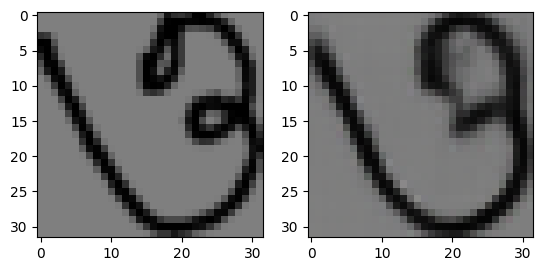

In [ ]:
model.load_state_dict(torch.load('model.pth'))

model.eval()
with torch.no_grad():
    for data in random.sample(list(test_loader), 1):
        imgs, _ = data
        imgs = imgs.to(DEVICE)
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(121)
        plt.imshow(np.squeeze(img))
        z, mu, logvar, out = model(imgs)
        print(z.shape, z)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg))
        break

In [ ]:
new_df = df[['Path', 'Label', 'Set']]
new_df

,Path,Label,Set
0,/content/Dataset/Train/200/bcc000183.bmp,200,Train
1,/content/Dataset/Train/200/bcc000108.bmp,200,Train
2,/content/Dataset/Train/200/bcc000145.bmp,200,Train
3,/content/Dataset/Train/200/bcc000171.bmp,200,Train
4,/content/Dataset/Train/200/bcc000082.bmp,200,Train
...,...,...,...
14995,/content/Dataset/Test/181/bcc000020.bmp,181,Test
14996,/content/Dataset/Test/181/bcc000015.bmp,181,Test
14997,/content/Dataset/Test/181/bcc000055.bmp,181,Test
14998,/content/Dataset/Test/181/bcc000016.bmp,181,Test


In [ ]:
def embedding(path):
    img = cv2.imread(path)
    img = transform(img).unsqueeze(0).to(DEVICE)
    z, mu, logvar, out = model(img)
    z = z.squeeze(0).cpu().detach().numpy()
    # mu = mu.squeeze(0).cpu().detach().numpy()
    # return z + mu
    return z

# All Images + All Images (Avg)

In [ ]:
model.load_state_dict(torch.load('model.pth'))

embeddings = []
all_images = new_df['Path'].values

for idx in tqdm(range(len(new_df))):
    img_path = all_images[idx]
    z = embedding(img_path)
    embeddings.append(z)
    # print(z.shape, z)
    # break

100%|██████████| 15000/15000 [00:29<00:00, 508.07it/s]


In [ ]:
embedding_df = pd.DataFrame(embeddings)

merged_df = pd.concat([new_df, embedding_df], axis=1)
merged_df

,Path,Label,Set,0,1,2,3,4,5,6,...,54,55,56,57,58,59,60,61,62,63
0,/content/Dataset/Train/200/bcc000183.bmp,200,Train,0.449014,0.778657,-0.506636,-0.843453,0.131447,-1.694207,1.154667,...,0.158981,-1.510968,0.550720,-0.596040,-0.904045,0.660029,0.587540,-0.597252,-1.757158,-0.032970
1,/content/Dataset/Train/200/bcc000108.bmp,200,Train,0.058561,-1.881547,-1.038015,-0.414281,-0.774461,-2.037004,-0.056178,...,0.404317,0.164258,0.889629,0.166269,0.893989,2.252679,1.163357,-1.002920,0.835546,-0.151262
2,/content/Dataset/Train/200/bcc000145.bmp,200,Train,-2.542963,0.010215,0.305425,-4.546566,-1.597797,0.280792,-0.120742,...,-0.703170,1.277407,-0.862311,-0.588531,-0.377144,-0.480965,1.282126,0.149194,0.569169,0.691228
3,/content/Dataset/Train/200/bcc000171.bmp,200,Train,-0.000698,-0.517203,0.132427,1.032968,-1.443779,-0.648356,-0.218659,...,0.846791,-0.688834,-0.233461,0.878635,-0.370423,-0.201477,0.293249,-0.630792,1.512704,1.208886
4,/content/Dataset/Train/200/bcc000082.bmp,200,Train,0.564102,-0.302913,-0.311950,-1.236649,0.575638,0.395609,0.176786,...,0.919317,-0.630414,0.536898,-0.066134,-0.463104,1.100928,0.541558,0.665055,-0.957743,-0.287488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,/content/Dataset/Test/181/bcc000020.bmp,181,Test,0.611252,0.746395,1.927815,-0.603155,1.940938,0.134496,-1.472906,...,-0.434276,1.646213,0.507205,0.369606,1.440507,-0.892543,0.038736,0.192348,-0.445213,-1.611101
14996,/content/Dataset/Test/181/bcc000015.bmp,181,Test,0.070296,-0.323123,0.860967,-0.175660,1.090943,0.640811,-2.134380,...,-0.611376,1.320473,-0.786251,-0.168256,0.322903,-1.377830,0.300816,0.582079,-0.299635,-1.097852
14997,/content/Dataset/Test/181/bcc000055.bmp,181,Test,-0.644868,-0.770556,1.900539,2.647653,0.568907,0.980394,0.118349,...,1.107263,1.365645,-0.258479,-0.042472,0.032533,-0.532124,0.381548,0.899260,0.315173,-0.504565
14998,/content/Dataset/Test/181/bcc000016.bmp,181,Test,0.159447,1.084975,0.552469,0.242871,1.255396,0.178238,0.787235,...,0.532395,2.116820,0.263264,0.357464,0.186184,-0.521880,-0.701471,1.772911,-1.476246,-1.295987


In [ ]:
merged_df.to_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAECustom/all_images.csv', index=False)

In [ ]:
pd.read_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAECustom/all_images.csv')

,Path,Label,Set,0,1,2,3,4,5,6,...,54,55,56,57,58,59,60,61,62,63
0,/content/Dataset/Train/200/bcc000183.bmp,200,Train,0.449014,0.778657,-0.506636,-0.843453,0.131447,-1.694207,1.154667,...,0.158981,-1.510968,0.550720,-0.596040,-0.904045,0.660029,0.587540,-0.597252,-1.757158,-0.032970
1,/content/Dataset/Train/200/bcc000108.bmp,200,Train,0.058561,-1.881547,-1.038015,-0.414281,-0.774461,-2.037005,-0.056178,...,0.404317,0.164258,0.889629,0.166269,0.893989,2.252679,1.163358,-1.002920,0.835546,-0.151262
2,/content/Dataset/Train/200/bcc000145.bmp,200,Train,-2.542963,0.010215,0.305425,-4.546566,-1.597797,0.280792,-0.120742,...,-0.703170,1.277407,-0.862311,-0.588531,-0.377144,-0.480965,1.282126,0.149194,0.569169,0.691228
3,/content/Dataset/Train/200/bcc000171.bmp,200,Train,-0.000698,-0.517203,0.132427,1.032968,-1.443779,-0.648356,-0.218659,...,0.846791,-0.688834,-0.233461,0.878635,-0.370423,-0.201477,0.293249,-0.630792,1.512704,1.208886
4,/content/Dataset/Train/200/bcc000082.bmp,200,Train,0.564102,-0.302913,-0.311950,-1.236649,0.575638,0.395609,0.176786,...,0.919318,-0.630414,0.536898,-0.066134,-0.463104,1.100928,0.541558,0.665055,-0.957743,-0.287488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,/content/Dataset/Test/181/bcc000020.bmp,181,Test,0.611252,0.746395,1.927815,-0.603155,1.940938,0.134496,-1.472905,...,-0.434276,1.646213,0.507205,0.369606,1.440507,-0.892543,0.038736,0.192348,-0.445213,-1.611101
14996,/content/Dataset/Test/181/bcc000015.bmp,181,Test,0.070296,-0.323122,0.860967,-0.175660,1.090942,0.640811,-2.134380,...,-0.611376,1.320473,-0.786251,-0.168256,0.322903,-1.377830,0.300816,0.582079,-0.299635,-1.097851
14997,/content/Dataset/Test/181/bcc000055.bmp,181,Test,-0.644868,-0.770556,1.900539,2.647653,0.568907,0.980394,0.118349,...,1.107263,1.365645,-0.258479,-0.042472,0.032533,-0.532124,0.381549,0.899260,0.315173,-0.504565
14998,/content/Dataset/Test/181/bcc000016.bmp,181,Test,0.159447,1.084975,0.552469,0.242871,1.255396,0.178238,0.787235,...,0.532394,2.116820,0.263264,0.357464,0.186184,-0.521880,-0.701471,1.772911,-1.476246,-1.295987


In [ ]:
embd_all_images = {}
embd_all_images_avg = {}

for i in range(172, 172+50):
    temp_df = merged_df.loc[merged_df['Label'] == str(i)]
    values = temp_df.iloc[:, 3:].values
    values = np.sum(values, axis=0)

    embd_all_images[i] = values
    embd_all_images_avg[i] = values/len(temp_df)

embd_all_images_df = pd.DataFrame(embd_all_images)
embd_all_images_avg_df = pd.DataFrame(embd_all_images_avg)

embd_all_images_df.to_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAECustom/embd_all_images.csv', index=False)
embd_all_images_avg_df.to_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAECustom/embd_all_images_avg_df.csv', index=False)

In [ ]:
pd.read_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAECustom/embd_all_images_avg_df.csv')

,172,173,174,175,176,177,178,179,180,181,...,212,213,214,215,216,217,218,219,220,221
0,0.142743,0.105134,0.110020,-0.330813,0.484989,0.339039,-0.153652,0.756572,0.879756,-0.143492,...,-0.271123,-0.777548,-0.712530,-0.339756,0.043789,-0.135221,-0.620508,-0.134061,-0.807910,0.973151
1,0.016158,0.270939,-0.374213,-0.568948,0.049000,-0.152383,-0.259732,-0.340559,-0.061391,-0.064761,...,0.116567,0.171029,-0.180904,-0.458009,-0.110343,-0.212472,0.232411,-0.283589,0.238338,0.411433
2,0.023925,-0.811135,0.090888,0.024047,0.754572,0.187461,0.924299,0.063219,-0.495908,1.440451,...,-0.433026,-0.635915,-1.391017,-0.573315,-0.980610,-0.434767,1.399607,-0.922966,-0.186193,1.074733
3,0.457859,-0.130947,0.090295,-0.161169,-0.117723,0.262456,-0.168211,0.470237,0.536295,-0.179220,...,-0.379276,0.093221,-0.576882,0.267065,-0.664815,-0.052119,0.019697,0.071005,-0.414930,-0.375585
4,-0.097633,-0.275333,0.388466,-0.372668,0.297313,0.272928,-0.533117,1.186537,0.691805,1.014277,...,-0.227294,-0.206045,0.008500,-0.046869,-0.901070,-0.069639,-0.513445,-0.435963,-0.472294,0.739167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.248976,0.273566,-0.208242,-0.308801,-0.686964,-1.081411,0.046261,-1.328866,-0.835002,-0.970134,...,0.584699,0.345825,-0.251340,-0.071726,-0.077076,1.064529,0.525671,-0.018057,-1.205604,-2.193119
60,-0.056404,-0.492741,-0.452371,-0.683182,0.389945,-0.071913,-0.238866,-0.379111,-0.315573,0.600157,...,0.035466,-0.358870,0.024321,0.484252,0.637854,0.187218,0.889198,-0.234793,0.890543,0.145590
61,-0.501654,-0.370293,-0.613716,-0.416313,-0.132596,-0.248957,-0.313143,0.158405,-0.022781,0.415150,...,-0.678644,0.311197,-0.351909,1.008615,0.523036,-0.155176,-0.252187,-0.319973,-1.173657,0.590210
62,-0.426558,-0.298773,0.743843,0.330312,-0.099701,-0.070314,0.159858,-0.063393,0.450381,0.116691,...,1.119778,-0.008590,0.300169,-0.957647,0.547888,0.423880,-1.321093,-0.768587,-0.715080,-0.887874


In [ ]:
random.randint(1, 10)

7

In [ ]:
embd_random1 = {}

for i in range(172, 172+50):
    temp_df = merged_df.loc[merged_df['Label'] == str(i)]
    temp_df.reset_index(drop=True, inplace=True)

    value = temp_df.iloc[random.randint(0, len(temp_df)), :][3:].values

    embd_random1[i] = value

embd_random1_df = pd.DataFrame(embd_random1)

embd_random1_df.to_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAECustom/embd_random1.csv', index=False)

In [ ]:
pd.read_csv("/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAECustom/embd_random1.csv")

,172,173,174,175,176,177,178,179,180,181,...,212,213,214,215,216,217,218,219,220,221
0,-1.021904,-0.117365,0.329248,-1.821474,1.773188,0.641423,-0.767983,-0.062170,-0.366751,0.343006,...,0.376138,-0.648362,-0.273323,-0.930935,-1.368559,-2.203418,-0.342771,0.316810,-0.817569,-1.678894
1,-0.271780,1.516984,-0.431175,0.982842,-0.231530,-0.079025,0.000870,-1.312388,-0.671755,0.095431,...,0.419304,1.364459,-0.357079,-0.485020,-0.452844,-0.200718,0.662524,0.119277,0.556899,-2.332939
2,-2.150063,-0.039712,0.083708,0.720996,0.742257,-0.415318,-0.381256,0.048999,-2.267538,0.504556,...,1.938372,-1.064994,-1.669094,-0.098421,-1.813588,-0.075026,0.159017,-0.989045,-1.783145,-0.108789
3,-0.031137,0.669379,-1.910724,-1.460105,0.976145,1.026729,-0.358233,0.482110,-0.807359,-0.501785,...,-1.224895,-0.591680,0.975575,1.884930,-1.041555,1.439595,1.305845,0.686831,-0.244429,0.318733
4,-1.079380,0.658551,-1.439435,-0.997624,0.500163,0.498617,0.190775,1.221416,0.279814,-1.761951,...,-0.341182,0.329179,-0.387052,0.598534,-1.048741,0.597907,-0.700961,1.729698,0.020009,1.019677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,1.315595,0.445748,-1.227514,-1.585326,-0.980115,-0.151202,-1.006880,-1.499388,0.541384,0.314280,...,0.011909,0.123711,-1.195105,0.763457,-0.146520,2.668798,-0.568674,1.977340,-1.455809,-1.009081
60,-0.536608,-2.000716,-1.820583,-1.353767,0.212618,-0.665140,-0.748838,-0.973215,-1.486723,0.458629,...,0.434950,0.452446,-1.123118,-0.302425,-0.268873,-1.907462,2.035786,-1.608264,0.426433,-1.122237
61,-0.914977,-0.142406,-0.609365,0.450505,0.497465,-0.101385,0.264055,-0.321569,-0.475938,0.015526,...,-1.727811,1.191308,0.172774,1.316988,0.200153,1.103326,2.229070,-0.505604,-1.985584,-0.385297
62,-2.369468,1.626948,-0.360044,0.990072,-0.749855,-0.659113,0.238474,-0.117745,1.507979,0.519412,...,1.809778,-0.446476,2.277827,-0.071660,1.864392,0.619733,-4.086333,0.894525,-0.957026,-0.770072


In [ ]:
embd_all_images = {}
embd_all_images_avg = {}

for i in range(172, 172+50):
    temp_df = merged_df.loc[merged_df['Label'] == str(i)]
    values = temp_df.iloc[:, 3:].values
    values = np.sum(values, axis=0)

    embd_all_images[i] = values
    embd_all_images_avg[i] = values/len(temp_df)

embd_all_images_df = pd.DataFrame(embd_all_images)
embd_all_images_avg_df = pd.DataFrame(embd_all_images_avg)

embd_all_images_df.to_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAECustom/embd_all_images.csv', index=False)
embd_all_images_avg_df.to_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAECustom/embd_all_images_avg_df.csv', index=False)

In [ ]:
N = 10
embd_random10 = {}
embd_random10_avg = {}

for i in range(172, 172+50):
    temp_df = merged_df.loc[merged_df['Label'] == str(i)]
    temp_df.reset_index(drop=True, inplace=True)

    idxs = [random.randint(0, len(temp_df)-1) for _ in range(N)]

    temp_df = temp_df.loc[idxs, :]

    values = temp_df.iloc[:, 3:].values
    values = np.sum(values, axis=0)

    embd_random10[i] = values
    embd_random10_avg[i] = values/len(temp_df)

embd_random10_df = pd.DataFrame(embd_random10)
embd_random10_avg_df = pd.DataFrame(embd_random10_avg)

embd_random10_df.to_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAECustom/embd_random10.csv', index=False)
embd_random10_avg_df.to_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAECustom/embd_random10_avg.csv', index=False)

In [ ]:
pd.read_csv("/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAECustom/embd_random10_avg.csv")

,172,173,174,175,176,177,178,179,180,181,...,212,213,214,215,216,217,218,219,220,221
0,-0.023813,0.214127,0.147549,-0.399809,0.132557,0.599045,0.015434,0.739862,0.968083,-0.642068,...,-0.388538,-0.403468,-0.618731,-0.170049,0.022815,-0.393963,-0.582768,-0.087207,-0.348252,0.403229
1,-0.166987,0.055476,-0.343266,-0.305276,0.117012,0.150258,-0.116122,-0.218038,0.475087,-0.155646,...,0.055394,0.184484,-0.306411,-0.457970,-0.086528,-0.298111,0.060460,-0.404097,0.270650,0.018862
2,0.059564,-1.424477,-0.044495,0.070534,0.431582,0.320487,0.317927,-0.097555,-0.497738,1.251538,...,-1.193630,-0.605404,-1.074803,-0.599634,-1.211950,-0.959931,1.261111,-0.676399,0.122494,1.110551
3,0.787203,0.454064,0.354663,-0.292198,0.063357,0.162343,0.317737,0.257337,0.302746,-0.255659,...,-0.014051,0.352110,-0.695865,0.095044,-0.740647,0.045581,0.004429,0.353086,-0.638573,-0.374031
4,-0.077939,-0.408589,0.369664,-0.536595,0.034904,0.145192,-0.611630,1.062534,0.227554,0.646055,...,0.414793,0.125513,0.106698,-0.013282,-0.791256,-1.156097,-0.616124,-0.244849,-0.955490,0.652414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.389470,0.874762,-0.370047,-0.655671,-1.245375,-0.990689,0.441760,-1.446268,-0.949935,-0.794607,...,0.524202,0.422467,-0.428128,0.005996,-0.134477,0.655916,0.609202,0.563888,-0.928833,-1.698492
60,-0.851456,-0.679225,-0.432673,-0.766618,0.650436,0.121888,-0.677265,-0.402284,-0.126782,0.482086,...,-0.557211,-0.549398,0.538673,0.465743,0.408749,0.732272,1.174730,-0.667306,1.171900,0.102091
61,-0.663657,-0.232190,-0.794254,-0.279064,-0.100747,-0.396077,-0.439673,0.009046,0.120587,0.277155,...,-0.344344,0.291374,-0.556405,0.893753,0.293320,-0.478712,-0.349697,-0.237213,-1.434237,0.549165
62,0.119972,-0.146671,0.794445,0.182065,-0.162205,0.125429,0.031078,-0.245004,0.568724,0.016091,...,1.056473,0.051404,0.256215,-0.597057,0.843187,0.121075,-1.260028,-0.330975,-0.960354,-0.816599


In [ ]:
N = 50
embd_random50 = {}
embd_random50_avg = {}

for i in range(172, 172+50):
    temp_df = merged_df.loc[merged_df['Label'] == str(i)]
    temp_df.reset_index(drop=True, inplace=True)

    idxs = [random.randint(0, len(temp_df)-1) for _ in range(N)]

    temp_df = temp_df.loc[idxs, :]

    values = temp_df.iloc[:, 3:].values
    values = np.sum(values, axis=0)

    embd_random50[i] = values
    embd_random50_avg[i] = values/len(temp_df)

embd_random50_df = pd.DataFrame(embd_random50)
embd_random50_avg_df = pd.DataFrame(embd_random50_avg)

embd_random50_df.to_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAECustom/embd_random50_df.csv', index=False)
embd_random50_avg_df.to_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAECustom/embd_random50_avg_df.csv', index=False)

In [ ]:
N = 100
embd_random100 = {}
embd_random100_avg = {}

for i in range(172, 172+50):
    temp_df = merged_df.loc[merged_df['Label'] == str(i)]
    temp_df.reset_index(drop=True, inplace=True)

    idxs = [random.randint(0, len(temp_df)-1) for _ in range(N)]

    temp_df = temp_df.loc[idxs, :]

    values = temp_df.iloc[:, 3:].values
    values = np.sum(values, axis=0)

    embd_random100[i] = values
    embd_random100_avg[i] = values/len(temp_df)

embd_random100_df = pd.DataFrame(embd_random100)
embd_random100_avg_df = pd.DataFrame(embd_random100_avg)

embd_random100_df.to_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAECustom/embd_random100_df.csv', index=False)
embd_random100_avg_df.to_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAECustom/embd_random100_avg_df.csv', index=False)

In [ ]:
import pandas as pd
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [ ]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize((0.5), (0.5)),
])

embeddings = []
classes = []

for idx in range(172, 172+50):
    img_path = f'/content/Dataset/Test/{idx}/bcc000020.bmp'
    img = test_transform(cv2.imread(img_path))
    # print(img.shape)

    z, mu, logvar, out = model(img.unsqueeze(0).to(DEVICE))
    embd = z
    embd = embd.view(-1, embd.shape[1])
    # print(embd.shape, recon.shape)
    embeddings.append(list(embd[0].cpu().detach().numpy()))
    classes.append(idx)

np.array(embeddings).shape

(50, 32)

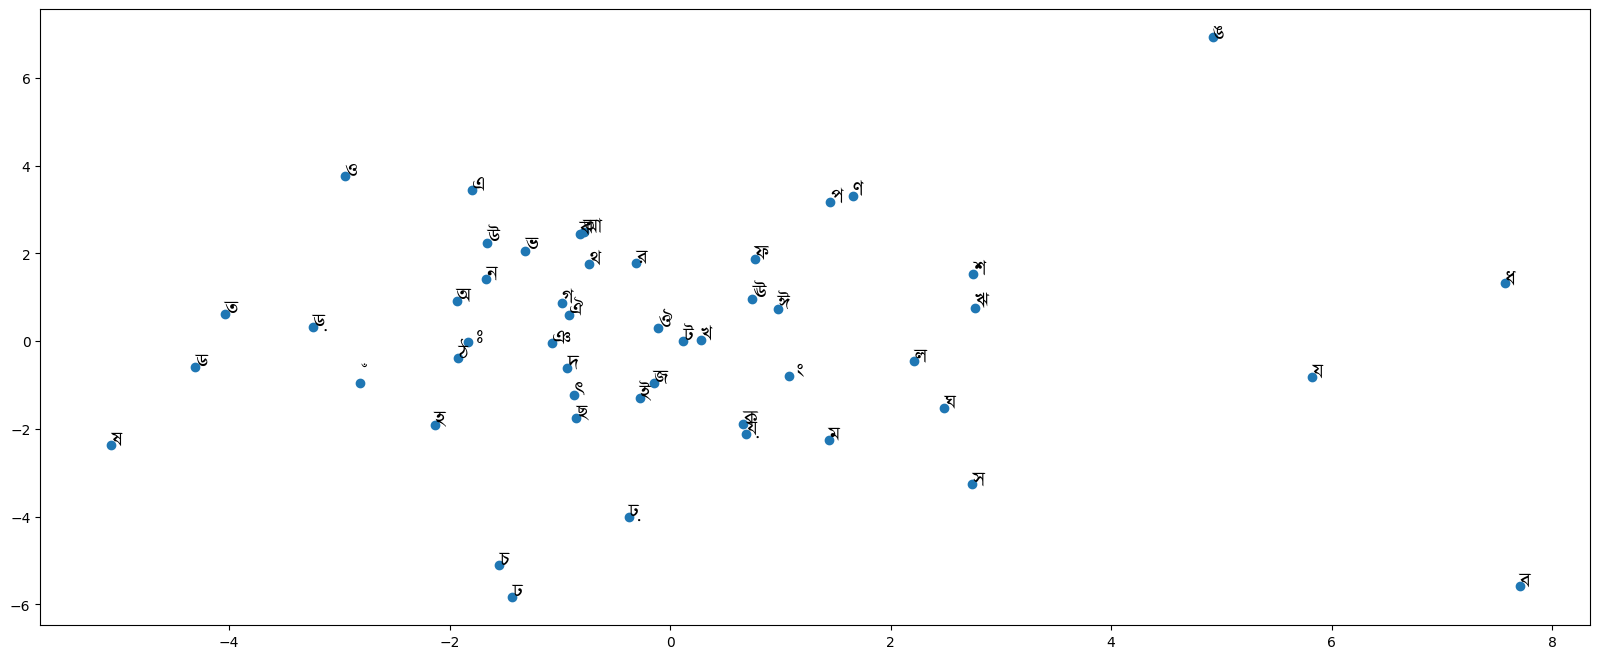

In [ ]:
prop = fm.FontProperties(fname='/content/drive/MyDrive/ZSClassification/VAEViT/Bangla/kalpurush.ttf')

X = embeddings
pca = PCA(n_components=2)
result = pca.fit_transform(X)

plt.figure(figsize=(20, 8))
plt.scatter(result[:, 0], result[:, 1])

chars = [
    'অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ', 'ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড',
    'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'হ', 'ড়', 'ঢ়', 'য়', 'ৎ',' ং',' ঃ', ' ঁ',
    # 'অনুস্বার','বিসর্গ', 'চন্দ্রবিন্দু'
]

for i, char in enumerate(chars):
    plt.annotate(
        char,
        xy = (result[i, 0], result[i, 1]),
        fontproperties=prop,
        fontsize=15
    )

plt.show()

In [ ]:
df = pd.DataFrame(embeddings)
df['Class'] = classes
df.to_csv('/content/drive/MyDrive/ZSClassification/VAEViT/Bangla/BanglaVAESingle.csv', index=False)

In [ ]:
pd.read_csv('/content/drive/MyDrive/ZSClassification/VAEViT/Bangla/BanglaVAESingle.csv')

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,Class
0,0.826601,-0.643228,0.644723,-2.108765,1.959371,0.060883,2.652870,-0.332207,2.230372,0.595964,...,0.678269,-0.331549,-3.858577,0.793181,-0.699412,1.374440,-0.965482,-0.873526,-0.791988,172
1,3.736749,1.637350,-2.625059,-1.460237,-0.556708,1.272279,0.482792,0.731435,2.214306,-0.328877,...,1.891903,2.809788,-0.506467,0.697121,-1.162924,-0.857342,-2.239981,0.796172,1.427653,173
2,-0.040944,0.796215,0.918663,-0.261428,0.678231,-0.200453,0.895466,-0.349800,-0.066551,-1.098631,...,-2.083966,1.135637,0.726843,0.696616,2.022157,1.513507,0.426078,0.129852,-0.354947,174
3,-1.889292,1.616049,1.379666,1.982368,2.118025,0.742107,-0.686495,1.198862,1.176368,2.170379,...,1.820336,0.830886,0.160675,1.117020,-0.658923,-1.391240,0.012814,-0.296098,2.750925,175
4,-1.389715,-0.624717,-1.685383,-0.746781,1.716130,0.805919,-0.846912,0.090554,-1.605566,0.257108,...,-0.078675,-0.351137,-1.091793,0.643995,1.096201,-0.487024,0.851399,-0.185929,0.432738,176
5,-0.604401,0.387451,-0.306259,-0.174870,-0.237058,1.625639,0.232531,0.435224,-1.438434,0.415707,...,-0.463129,-0.682788,0.476823,-0.411264,0.324976,-1.039316,-1.568914,-1.047128,-0.397039,177
6,-1.582053,-0.311623,0.606029,-0.197412,1.166133,0.541006,0.046544,-0.987694,1.261434,0.724388,...,-0.085431,-0.044068,0.206734,0.597506,-1.035706,-0.928640,-0.817498,-2.015711,-1.547561,178
7,0.386484,0.384573,-4.706202,1.528435,-0.300475,-1.518041,3.728112,-3.094047,-3.644237,0.084399,...,-0.405868,-0.850751,0.837200,0.029461,-0.964801,-1.131918,0.419230,-2.800137,0.530804,179
8,0.652930,0.192295,1.979060,1.379208,1.075105,0.024458,-1.042839,1.797479,0.519989,1.568434,...,1.264799,-0.415301,-1.570739,1.234959,1.005117,-1.096753,1.677053,-1.508980,-0.895949,180
9,1.973098,-0.533741,-1.265935,1.977097,1.654122,-2.480383,1.498891,-1.393463,-1.719841,1.066480,...,1.301729,-0.413112,1.813884,-0.001200,-0.244871,-0.113902,0.712959,1.668344,-0.885490,181


In [ ]:
embeddings = []
for idx in range(172, 172+50):
    # img_path = f'/content/DatasetBangla/Train/{idx}/'
    # imgs_paths = glob.glob(os.path.join(img_path, '*.*'))

    train_path = f'/content/Dataset/Train/{idx}/'
    train_imgs = glob.glob(os.path.join(train_path, '*.bmp'))

    test_path = f'/content/Dataset/Test/{idx}/'
    test_imgs = glob.glob(os.path.join(test_path, '*.bmp'))

    imgs_paths = train_imgs + test_imgs

    embeds = 0
    for img_path in imgs_paths:
        img = test_transform(cv2.imread(img_path))
        z, mu, logvar, out = model(img.unsqueeze(0).to(DEVICE))
        embd = z.cpu().detach().numpy().squeeze()
        embeds += embd

    embeds = embeds / len(imgs_paths)
    # print(embeds.shape, embeds)
    embeddings.append(embeds)

np.array(embeddings).shape

(50, 32)

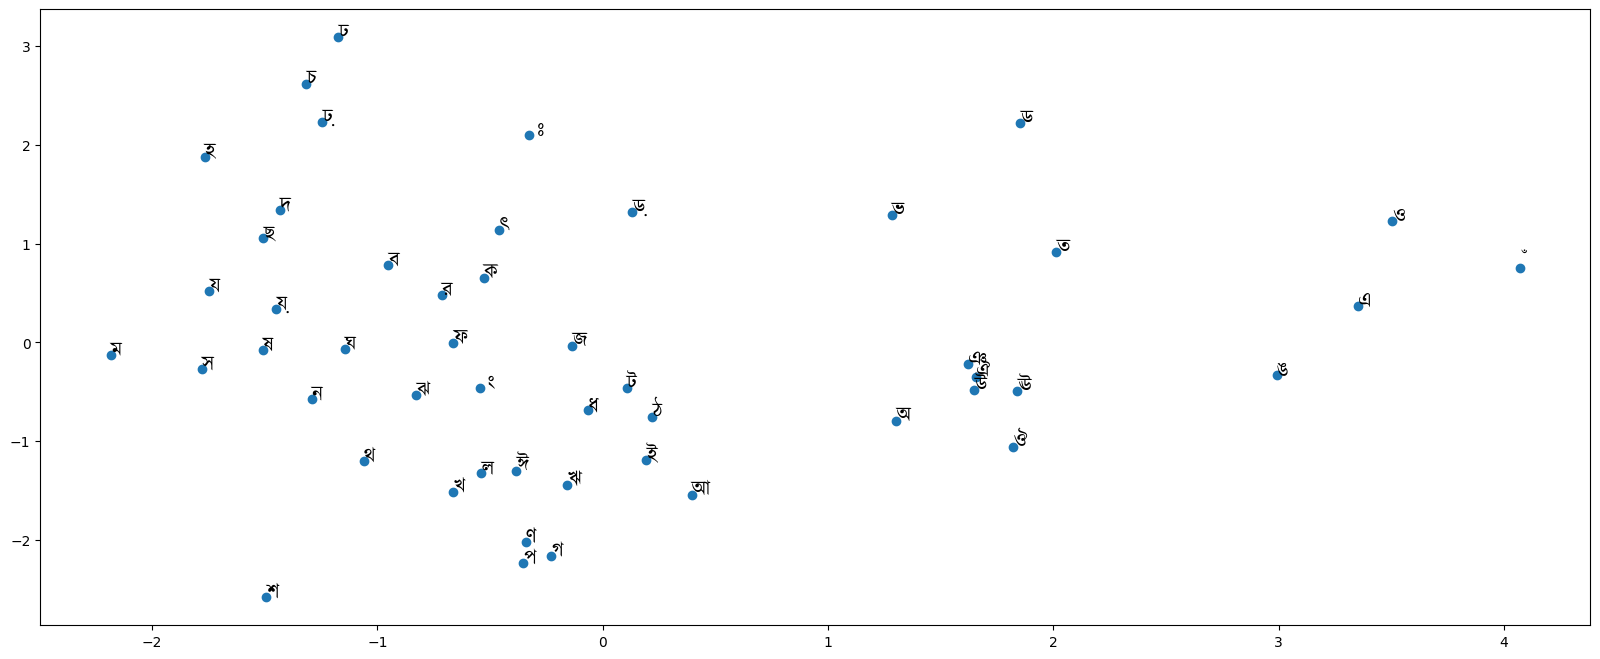

In [ ]:
prop = fm.FontProperties(fname='/content/drive/MyDrive/ZSClassification/VAEViT/Bangla/kalpurush.ttf')

X = embeddings
pca = PCA(n_components=2)
result = pca.fit_transform(X)

plt.figure(figsize=(20, 8))
plt.scatter(result[:, 0], result[:, 1])

chars = [
    'অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ', 'ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড',
    'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'হ', 'ড়', 'ঢ়', 'য়', 'ৎ',' ং',' ঃ', ' ঁ',
    # 'অনুস্বার','বিসর্গ', 'চন্দ্রবিন্দু'
]

for i, char in enumerate(chars):
    plt.annotate(
        char,
        xy = (result[i, 0], result[i, 1]),
        fontproperties=prop,
        fontsize=15
    )

plt.show()

In [ ]:
df = pd.DataFrame(embeddings)
df['Class'] = [_ for _ in range(172, 172+50)]
df.to_csv('/content/drive/MyDrive/ZSClassification/VAEViT/Bangla/BanglaVAEMean.csv', index=False)

In [ ]:
pd.read_csv('/content/drive/MyDrive/ZSClassification/VAEViT/Bangla/BanglaVAEMean.csv')

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,Class
0,0.224432,-0.853822,-0.969172,-0.163280,-0.206675,-0.156833,1.127503,-0.992066,1.059984,0.362823,...,0.858383,-0.820510,-0.809624,0.091335,-0.346087,0.275003,-0.819448,0.625088,-0.273669,172
1,0.851991,-0.043545,-0.915231,-0.164573,0.034638,-0.207057,0.316868,-1.788211,0.734384,0.606281,...,-0.392102,-0.297499,-1.146431,0.909493,-0.451957,0.046817,-0.836126,0.320403,0.647409,173
2,-0.529589,0.388332,0.377333,-0.062079,0.622375,1.430314,-0.766472,0.867949,-0.074874,-0.578985,...,0.178268,-0.313943,-0.387799,-0.116724,0.270182,-0.650512,0.535186,-0.320670,0.654528,174
3,-0.999995,0.345786,0.769604,0.347072,0.079885,0.948441,-0.710789,0.894269,-0.102432,-0.215492,...,-0.160599,0.114267,-0.255144,0.307728,0.084192,-0.334329,-0.397276,-0.457926,0.979654,175
4,0.426521,-0.195800,0.363893,-0.011155,0.465291,0.413461,-0.568482,0.281516,-0.862868,-0.368040,...,0.399159,0.428860,-0.403621,0.033043,0.721691,-0.810929,0.177303,-0.212001,-0.330528,176
5,0.045387,0.150965,-0.344388,0.324279,0.408732,0.409082,0.151386,0.823832,-1.164977,-0.678006,...,-0.138858,0.014453,-0.484614,0.037975,1.018518,-0.721365,0.048352,-0.296173,-0.012248,177
6,-1.698954,-0.851240,0.059178,0.569577,0.498584,0.194991,-0.793716,-0.369191,0.353798,0.190228,...,0.013940,0.103272,0.057208,-0.082290,-0.860837,-0.719525,-0.750888,-0.502629,-0.121507,178
7,-0.618184,-0.656365,-1.012339,0.255168,-0.184739,-1.596663,2.296070,-0.975852,-2.132984,-0.294270,...,-0.310713,-0.134044,-0.913060,-1.076355,0.906515,-0.538593,0.337439,-0.340129,-0.620530,179
8,-0.318522,-0.141155,-0.440288,0.149471,0.760625,0.106088,0.564407,0.540157,-0.899747,0.039148,...,0.107159,-0.826902,-1.050706,-0.189299,0.682585,-0.432513,1.022537,-1.373820,0.515652,180
9,0.989945,-0.412908,0.511537,0.701074,-0.265188,-0.882063,2.039047,-0.024316,-2.095788,0.437936,...,-0.164901,0.411150,0.705925,-0.287891,-0.672088,-0.394884,0.503995,1.188120,-0.891649,181
